
#1. Sintonía de un controlador PID para el nivel de un tanque

En este primer caso, PSO se aplica a un problema clásico de control industrial: la regulación del nivel de un tanque mediante una válvula.

Descripción del proceso:

El tanque se modela como un sistema de primer orden con retardo (FOPDT), lo que representa el comportamiento real de procesos físicos con inercia y transporte de masa.
El controlador PID (Proporcional–Integral–Derivativo) busca mantener el nivel deseado (setpoint) a pesar de perturbaciones externas, como cambios de flujo o fugas.

Objetivo de la optimización:

El PSO ajusta automáticamente las ganancias del controlador (Kp, Ki, Kd) para lograr el mejor comportamiento dinámico posible.
La función de costo combina varios criterios de desempeño:

- IAE (Integral Absolute Error): mide el error acumulado.

- Sobrepaso: penaliza respuestas demasiado agresivas.

- Tiempo de asentamiento: busca respuestas rápidas y estables.

- Suavidad de control: evita acciones de válvula demasiado bruscas.

De esta manera, PSO encuentra un equilibrio entre rapidez, estabilidad y eficiencia, tal como lo haría un ingeniero de control en una planta real.

Resultados

El algoritmo muestra la convergencia del enjambre, el valor óptimo de cada parámetro PID y las curvas de respuesta temporal del sistema:

- Señal del nivel (salida),

- Setpoint (referencia),

- Acción de control aplicada por la válvula.

Este ejemplo evidencia cómo PSO puede aplicarse en automatización industrial, control de procesos y mantenimiento predictivo para ajustar parámetros complejos sin requerir gradientes analíticos.
#

#2. Planificación de rutas logísticas (Vehicle Routing Problem)

El segundo caso traslada PSO a un contexto de logística y transporte, resolviendo una versión simplificada del Capacitated Vehicle Routing Problem (CVRP).

Descripción del escenario:

Un centro de distribución debe atender a varios clientes dispersos en una zona geográfica.
Cada cliente tiene una demanda de productos, y la empresa dispone de un número limitado de vehículos con capacidad máxima de carga.

El objetivo es minimizar los costos operativos, combinando:

- Distancia total recorrida,

- Número de vehículos usados,

- Penalizaciones por violar restricciones (capacidad o exceso de vehículos).

Representación de las soluciones:

Cada partícula del enjambre contiene una lista de “random keys”, números continuos que determinan el orden de visita de los clientes.
Ordenando estos valores se obtiene una secuencia de entrega, y al llenar la capacidad del vehículo se divide automáticamente la ruta.

Este enfoque convierte un problema combinatorio complejo en uno continuo, donde PSO puede operar naturalmente.

Resultados

El algoritmo muestra la convergencia del costo total y un mapa de las rutas óptimas:

- Cada color representa un vehículo diferente.

- Se visualizan las conexiones entre el depósito y los clientes en orden de visita.

De esta forma, PSO se convierte en una herramienta versátil para problemas de optimización logística, planificación de entregas, última milla o incluso gestión de flotas autónomas.

===== Resultado PSO (PID) =====
Mejor costo J*: 18.9369
Kp=7.0867, Ki=0.4314, Kd=2.0000


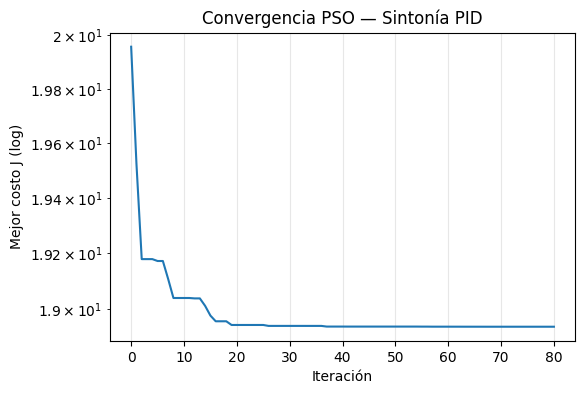

Overshoot: 0.00% | Ts≈ 2.05 s | IAE≈ 17.759 | Σ|Δu|≈ 1.527


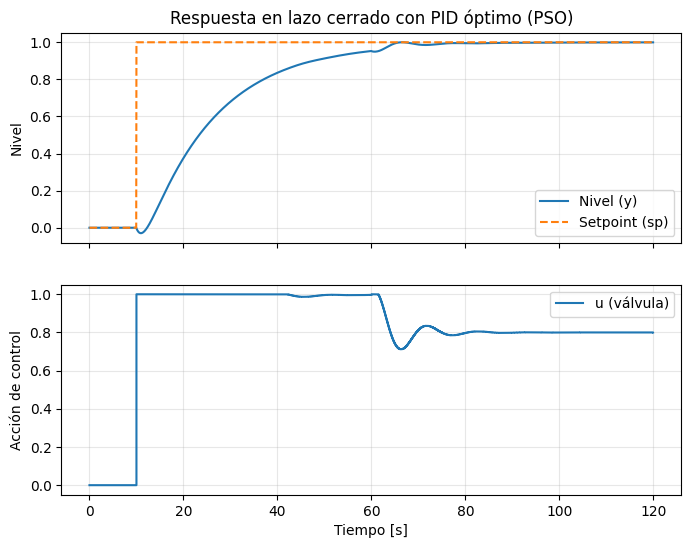

In [4]:
# ============================================================
# PSO aplicado: Sintonía de PID para control de nivel de tanque
# ------------------------------------------------------------
# - Proceso: 1er orden con retardo (FOPDT aproximado con Pade)
# - Objetivo: minimizar J = w1*IAE + w2*Overshoot(%) + w3*Ts + w4*|Δu|
# - Perturbación: escalón de entrada de perturbación en t = 60 s
# - Salidas: curvas de convergencia, respuesta con PID óptimo, esfuerzo de control
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # reproducibilidad

# ------------------------------
# 1) Parámetros del "proceso"
# ------------------------------
# Modelo FOPDT: Gp(s) = K / (tau s + 1) * e^{-L s}
# Usamos una aproximación de Padé de orden 1 para el retardo: e^{-Ls} ~ (1 - Ls/2) / (1 + Ls/2)
Kp_proc = 1.0   # ganancia del proceso (no confundir con Kp del PID)
tau = 15.0      # constante de tiempo (s)
L = 3.0         # retardo (s)  -> lo aproximamos con Pade(1)

# ------------------------------
# 2) Simulación discreta
# ------------------------------
dt = 0.05       # paso de integración (s)
T_sim = 120.0   # horizonte de simulación (s)
N = int(T_sim / dt)

# Setpoint y perturbación
sp = np.zeros(N)
sp[int(10.0/dt):] = 1.0  # escalón a 1.0 m en t=10s

d = np.zeros(N)
d[int(60.0/dt):] = 0.2   # perturbación (entrada aditiva) desde t=60s

# Saturación de actuador (válvula de 0 a 1)
U_MIN, U_MAX = 0.0, 1.0

# --------------------------------
# 3) Simulador del proceso con PID
# --------------------------------
def simulate_pid(Kp, Ki, Kd, w1=1.0, w2=2.0, w3=0.5, w4=0.1, return_traces=False):
    """
    Simula lazo cerrado con PID paralelo:
      u = Kp*e + Ki*∫e dt + Kd*de/dt
    - Antiwindup: clamp del integrador cuando u satura.
    - Proceso: FOPDT con Pade(1). Se implementa en tiempo discreto por Euler.
    - Costo: J = w1*IAE + w2*Overshoot(%) + w3*Ts + w4*sum|Δu|
    """
    # Estados del proceso FOPDT con Pade(1)
    # Aproximación: G_total(s) = Kp_proc/(tau s + 1) * (1 - Ls/2)/(1 + Ls/2)
    # Puede representarse como sistema de 2 estados: uno del 1er orden y otro del Pade.
    # Implementaremos la cadena "filtro Pade" -> "planta 1er orden".
    # Entrada efectiva con Pade: upade_out ~ filtro de u+d
    upade = 0.0  # estado del filtro Pade
    y = 0.0      # salida (nivel)

    # PID states
    integ = 0.0
    e_prev = 0.0
    u_prev = 0.0

    # Para métricas
    iae = 0.0
    du_sum = 0.0
    y_max = -np.inf
    settled = False
    Ts = T_sim  # por defecto, si no asienta

    # Trazas
    yy, uu, ee = [], [], []


    # Filtro recursivo estable:
    a = (2.0 - (dt / (L/2 + 1e-9)))  # estabilización rústica; alternativa: usar control toolbox

    # Derivamos coeficientes una vez:
    k = (L/2.0) * (2.0/dt)
    A0 = 1 + k
    A1 = 1 - k
    # Y(z) * A0 + Y(z)*A1 z^{-1} = U(z) * (1 - k) + U(z) * (1 + k) z^{-1}
    # Forma recursiva: yk = ( (1 - k)*uk + (1 + k)*uk_1 - A1*yk_1 ) / A0
    upade_k_1 = 0.0
    uin_k_1 = 0.0

    # Planta 1er orden: y_dot = ( -y + Kp_proc * upade ) / tau
    for kstep in range(N):
        e = sp[kstep] - y
        # PID paralelo
        deriv = (e - e_prev) / dt
        u_unsat = Kp*e + Ki*integ + Kd*deriv

        # Saturación
        u = np.clip(u_unsat, U_MIN, U_MAX)

        # Anti-windup simple: solo integro si no hay saturación fuerte
        if np.isclose(u, u_unsat, atol=1e-6):
            integ += e * dt
        else:
            # Opcional: back-calculation podría usarse aquí
            pass

        # Entrada total a la planta (control + perturbación)
        u_in = u + d[kstep]

        # Filtro de retardo (Pade discreto por Tustin)
        upade_k = ((1 - k)*u_in + (1 + k)*uin_k_1 - (1 - k)*upade_k_1) / (1 + k)
        upade = upade_k

        # Dinámica de la planta 1er orden
        y_dot = (-y + Kp_proc * upade) / tau
        y = y + dt * y_dot

        # Métricas
        iae += abs(e) * dt
        du_sum += abs(u - u_prev)
        y_max = max(y_max, y)

        # Tiempo de asentamiento (2% banda) medido cuando se mantiene 2s en banda
        # Chequeo simple: si |e|<0.02 por 2s consecutivos
        if not settled:
            window = int(2.0/dt)
            if kstep > window:
                if np.all(np.abs(np.array([sp[kstep-i] - y for i in range(window)])) < 0.02):
                    Ts = kstep*dt
                    settled = True

        # actualizar previos y trazas
        e_prev = e
        u_prev = u
        upade_k_1 = upade_k
        uin_k_1 = u_in

        if return_traces:
            yy.append(y); uu.append(u); ee.append(e)

    overshoot_pct = max(0.0, (y_max - 1.0) * 100.0)  # sobrepaso en %
    J = w1*iae + w2*overshoot_pct + w3*Ts + w4*du_sum

    if return_traces:
        t = np.arange(N)*dt
        return J, np.array(t), np.array(yy), np.array(uu), np.array(ee), overshoot_pct, Ts, iae, du_sum
    else:
        return J

# -----------------------------------
# 4) PSO para optimizar (Kp, Ki, Kd)
# -----------------------------------
# Límites de búsqueda (razonables para válvula 0-1 y proceso lento)
BOUNDS = np.array([
    [0.0, 8.0],   # Kp
    [0.0, 2.0],   # Ki
    [0.0, 2.0],   # Kd
], dtype=float)

def fitness(params):
    Kp, Ki, Kd = params
    return simulate_pid(Kp, Ki, Kd)

# Parámetros PSO (estables)
W = 0.72
C1 = 1.49
C2 = 1.49
VEL_FRAC = 0.4

NUM_PART = 30
ITER = 80
DIM = 3

# Inicialización
low = BOUNDS[:,0]; high = BOUNDS[:,1]
X = np.random.uniform(low, high, size=(NUM_PART, DIM))
V = np.random.uniform(-(high-low)*VEL_FRAC, (high-low)*VEL_FRAC, size=(NUM_PART, DIM))

P = X.copy()
P_val = np.array([fitness(x) for x in X])
g_idx = np.argmin(P_val)
g_best = P[g_idx].copy()
g_best_val = P_val[g_idx]
hist = [g_best_val]

# PSO loop
for it in range(ITER):
    r1 = np.random.rand(NUM_PART, DIM)
    r2 = np.random.rand(NUM_PART, DIM)
    V = W*V + C1*r1*(P - X) + C2*r2*(g_best - X)
    V = np.clip(V, -(high-low)*VEL_FRAC, (high-low)*VEL_FRAC)

    X = X + V
    X = np.clip(X, low, high)

    F = np.array([fitness(x) for x in X])

    improved = F < P_val
    P[improved] = X[improved]
    P_val[improved] = F[improved]

    idx = np.argmin(P_val)
    if P_val[idx] < g_best_val:
        g_best_val = P_val[idx]
        g_best = P[idx].copy()

    hist.append(g_best_val)

print("===== Resultado PSO (PID) =====")
print(f"Mejor costo J*: {g_best_val:.4f}")
print(f"Kp={g_best[0]:.4f}, Ki={g_best[1]:.4f}, Kd={g_best[2]:.4f}")

# ---------------------------
# 5) Gráficas y validación
# ---------------------------
plt.figure(figsize=(6,4))
plt.plot(hist)
plt.yscale("log")
plt.xlabel("Iteración")
plt.ylabel("Mejor costo J (log)")
plt.title("Convergencia PSO — Sintonía PID")
plt.grid(True, alpha=0.3)
plt.show()

# Simular con el mejor PID y trazar
J, t, y, u, e, ov, Ts, iae, du = simulate_pid(*g_best, return_traces=True)
print(f"Overshoot: {ov:.2f}% | Ts≈ {Ts:.2f} s | IAE≈ {iae:.3f} | Σ|Δu|≈ {du:.3f}")

fig, ax = plt.subplots(2, 1, figsize=(8,6), sharex=True)
ax[0].plot(t, y, label="Nivel (y)")
ax[0].plot(t, sp, '--', label="Setpoint (sp)")
ax[0].set_ylabel("Nivel")
ax[0].set_title("Respuesta en lazo cerrado con PID óptimo (PSO)")
ax[0].grid(True, alpha=0.3); ax[0].legend()

ax[1].step(t, u, where='post', label="u (válvula)")
ax[1].set_xlabel("Tiempo [s]")
ax[1].set_ylabel("Acción de control")
ax[1].grid(True, alpha=0.3); ax[1].legend()
plt.show()


===== Resultado PSO — Ruteo Logístico =====
Costo total: 773.30
  - Distancia total: 673.30
  - Costo fijo por vehículos: 100.00 (vehículos usados: 4)
  - Penalizaciones: 0.00
Rutas (índices de clientes y demanda de cada ruta):
  Vehículo 01: [np.int64(4), np.int64(17), np.int64(0), np.int64(12)] | Demanda total = 25.0
  Vehículo 02: [np.int64(19), np.int64(15), np.int64(14), np.int64(13), np.int64(8)] | Demanda total = 28.0
  Vehículo 03: [np.int64(11), np.int64(18), np.int64(2), np.int64(7), np.int64(3), np.int64(5), np.int64(16)] | Demanda total = 26.0
  Vehículo 04: [np.int64(9), np.int64(10), np.int64(6), np.int64(1)] | Demanda total = 28.0


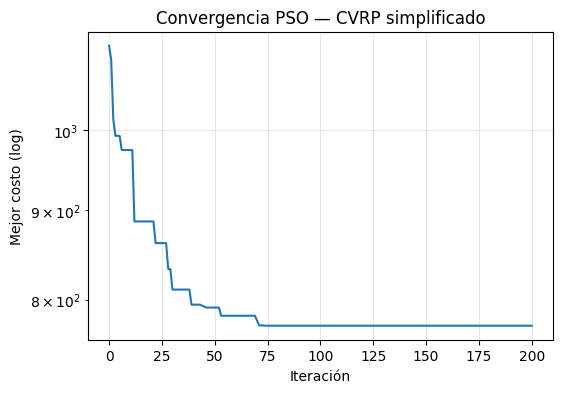

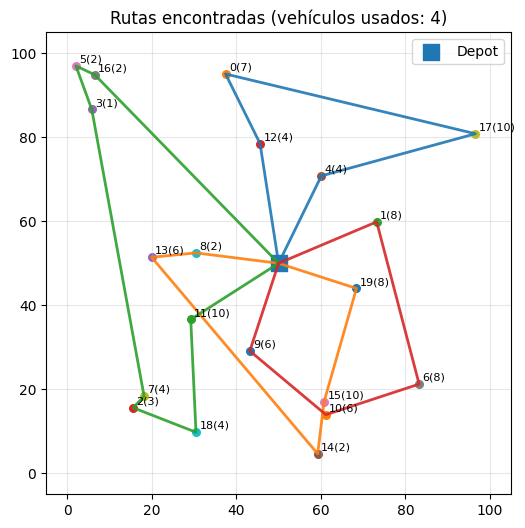

In [3]:
# ============================================================
# PSO para Logística (CVRP simplificado con random-keys)
# - Múltiples vehículos, una bodega (depot), demandas por cliente
# - Objetivo: distancia total + costo fijo por vehículo + penalizaciones
# - Decodificación: random-keys -> orden -> split por capacidad
# - Visualizaciones: convergencia y mapa de rutas
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # reproducibilidad

# ------------------------------
# 1) Instancia del problema
# ------------------------------
# Bodega / depósito
depot = np.array([50.0, 50.0])

# Genera un dataset reproducible y realista
N_CUSTOMERS = 20
coords = np.random.uniform(0, 100, size=(N_CUSTOMERS, 2))          # ubicaciones de clientes
demands = np.random.randint(1, 11, size=N_CUSTOMERS).astype(float)  # demanda [1..10] unidades

# Configuración de flota y costos
VEH_CAPACITY = 30.0
MAX_VEHICLES = 6
COST_PER_VEH = 25.0    # costo fijo por vehículo (puede representar costo de conductor + combustible de arranque)

# Penalizaciones (grandes para forzar factibilidad)
P_VEH_EXCESS = 1000.0     # por cada vehículo extra sobre MAX_VEHICLES
P_CAP_VIOL = 1000.0       # si alguna ruta excede capacidad (no debería con el split, pero por seguridad)
P_EMPTY_ROUTE = 0.0       # no penalizamos rutas vacías; simplemente no las contamos

# (Opcional) límite de longitud por ruta (turno/ventana). Comenta si no lo necesitas.
USE_ROUTE_LENGTH_LIMIT = False
ROUTE_LEN_MAX = 180.0
P_ROUTE_LEN = 200.0

# ------------------------------
# 2) Utilidades
# ------------------------------
def dist(a, b):
    return np.linalg.norm(a - b, ord=2)

def total_route_distance(route_idx):
    """Distancia de una ruta: depot -> c1 -> c2 -> ... -> depot"""
    if len(route_idx) == 0:
        return 0.0
    d = dist(depot, coords[route_idx[0]])
    for i in range(len(route_idx) - 1):
        d += dist(coords[route_idx[i]], coords[route_idx[i+1]])
    d += dist(coords[route_idx[-1]], depot)
    return d

def decode_random_keys(keys, demands, capacity):
    """
    Decodifica las prioridades (keys) en una lista de rutas.
    1) Ordena clientes por key ascendente
    2) Va agregando a la ruta actual hasta llenar la capacidad; si se excede, abre nueva ruta
    """
    order = np.argsort(keys)  # secuencia de visita
    routes = []
    current = []
    load = 0.0
    for idx in order:
        dmd = demands[idx]
        if load + dmd <= capacity or len(current) == 0:
            current.append(idx)
            load += dmd
        else:
            routes.append(current)
            current = [idx]
            load = dmd
    if len(current) > 0:
        routes.append(current)
    return routes

def evaluate_solution(keys):
    """
    Evalúa una solución dada por las keys (random-keys).
    Costo = suma de distancias + COST_PER_VEH * (#veh usados) + penalizaciones.
    """
    routes = decode_random_keys(keys, demands, VEH_CAPACITY)
    num_veh = len(routes)
    cost_dist = 0.0
    penalty = 0.0

    # Distancia y cheques
    for r in routes:
        # capacidad
        load = demands[r].sum() if len(r) > 0 else 0.0
        if load > VEH_CAPACITY + 1e-9:
            penalty += P_CAP_VIOL * (load - VEH_CAPACITY)

        # distancia
        d = total_route_distance(r)
        cost_dist += d

        # límite de longitud por ruta (si aplica)
        if USE_ROUTE_LENGTH_LIMIT and d > ROUTE_LEN_MAX:
            penalty += P_ROUTE_LEN * (d - ROUTE_LEN_MAX)

    # penalización por exceso de vehículos
    if num_veh > MAX_VEHICLES:
        penalty += P_VEH_EXCESS * (num_veh - MAX_VEHICLES)

    # costo fijo por vehículo
    cost_fixed = COST_PER_VEH * num_veh

    total_cost = cost_dist + cost_fixed + penalty
    return total_cost, routes, cost_dist, cost_fixed, penalty, num_veh

# --------------------------------
# 3) PSO (random-keys continuous)
# --------------------------------
DIM = N_CUSTOMERS                # una key por cliente
SWARM = 40
ITERS = 200
W = 0.72
C1 = 1.49
C2 = 1.49
VEL_CLAMP = 0.5                  # fracción del rango

# Rango de las keys (da igual, solo afectan el orden); mantener acotado ayuda estabilidad
KEY_LOW, KEY_HIGH = -1.0, 1.0
KEY_RANGE = KEY_HIGH - KEY_LOW

# Inicialización
X = np.random.uniform(KEY_LOW, KEY_HIGH, size=(SWARM, DIM))
V = np.random.uniform(-KEY_RANGE*VEL_CLAMP, KEY_RANGE*VEL_CLAMP, size=(SWARM, DIM))

# Mejores personales y globales
P = X.copy()
P_val = np.zeros(SWARM)
for i in range(SWARM):
    val, *_ = evaluate_solution(P[i])
    P_val[i] = val

g_idx = np.argmin(P_val)
g_best = P[g_idx].copy()
g_best_val = P_val[g_idx]
history = [g_best_val]

# Bucle principal PSO
for it in range(ITERS):
    r1 = np.random.rand(SWARM, DIM)
    r2 = np.random.rand(SWARM, DIM)
    V = W*V + C1*r1*(P - X) + C2*r2*(g_best - X)
    V = np.clip(V, -KEY_RANGE*VEL_CLAMP, KEY_RANGE*VEL_CLAMP)

    X = X + V
    X = np.clip(X, KEY_LOW, KEY_HIGH)

    F = np.zeros(SWARM)
    for i in range(SWARM):
        val, *_ = evaluate_solution(X[i])
        F[i] = val

    improved = F < P_val
    P[improved] = X[improved]
    P_val[improved] = F[improved]

    idx = np.argmin(P_val)
    if P_val[idx] < g_best_val:
        g_best_val = P_val[idx]
        g_best = P[idx].copy()

    history.append(g_best_val)

# Resultados finales
best_cost, best_routes, best_dist, best_fixed, best_pen, best_nveh = evaluate_solution(g_best)

print("===== Resultado PSO — Ruteo Logístico =====")
print(f"Costo total: {best_cost:.2f}")
print(f"  - Distancia total: {best_dist:.2f}")
print(f"  - Costo fijo por vehículos: {best_fixed:.2f} (vehículos usados: {best_nveh})")
print(f"  - Penalizaciones: {best_pen:.2f}")
print("Rutas (índices de clientes y demanda de cada ruta):")
for k, r in enumerate(best_routes, 1):
    print(f"  Vehículo {k:02d}: {r} | Demanda total = {demands[r].sum():.1f}")

# ------------------------------
# 4) Gráficas
# ------------------------------
# Convergencia
plt.figure(figsize=(6,4))
plt.plot(history)
plt.yscale("log")
plt.xlabel("Iteración")
plt.ylabel("Mejor costo (log)")
plt.title("Convergencia PSO — CVRP simplificado")
plt.grid(True, alpha=0.3)
plt.show()

# Mapa de rutas
colors = plt.cm.tab20(np.linspace(0,1,max(1,len(best_routes))))
plt.figure(figsize=(6,6))
plt.scatter(depot[0], depot[1], marker='s', s=120, label='Depot')

# Clientes
for i, (x, y) in enumerate(coords):
    plt.scatter(x, y, s=30)
    plt.text(x+0.8, y+0.8, f"{i}({int(demands[i])})", fontsize=8)

# Dibuja cada ruta
for i, r in enumerate(best_routes):
    c = colors[i % len(colors)]
    if len(r) == 0:
        continue
    # desde depot al primero
    path_x = [depot[0], coords[r[0], 0]]
    path_y = [depot[1], coords[r[0], 1]]
    # entre clientes
    for a, b in zip(r[:-1], r[1:]):
        path_x += [coords[b,0]]
        path_y += [coords[b,1]]
    # regreso a depot
    path_x += [depot[0]]
    path_y += [depot[1]]
    plt.plot(path_x, path_y, '-', alpha=0.9, linewidth=2)

plt.title(f"Rutas encontradas (vehículos usados: {best_nveh})")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-5,105); plt.ylim(-5,105)
plt.show()
